# Project: Popular Data Science Questions in Stack Exchange

In this project, we are working for a company that creates data science content and we are tasked with figuring out **what is best content to write about** - Given the lack of instructions there's some leeway in what "best" means here.

We will try to answer the **question**: 
- **"What is it that people want to learn about in data science?"** (as opposed to determining the most profitable content, for instance).

To answer this question we will analyze **Stack Overflow** (part of Stack Exchange), a question and answer website about programming and see what kind of content is more popular.

Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

About **Stack Exchange**:
- The site is all about getting answers. It's not a discussion forum. 
- Be specific and give details of what you want tried/want to achieve.
- Questions have: tags, votes, answers, views and dates (among others).

For this project **we will use the tags in the content**, so that we don not need to categorize it ourselves. 
    

To extract the data we will use the **Stack Exchange Data Explorer** (SEDE) capability (Transact-SQL). Tables that contain relevant data (among others):
- Tags
- Posts
- PostTags (link)
- Votes

LINK: https://data.stackexchange.com/datascience/query/edit/1379439

Query to extract questions (PostTypeId=1) posted in 2019:

    SELECT Id, PostTypeId, CreationDate, Score, ViewCount, 
      Tags, AnswerCount, FavoriteCount 
    FROM Posts
    WHERE 
    PostTypeId = 1 AND YEAR(CreationDate) = 2019; 

# Exploring the Data

In [230]:
#Load libraries
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [231]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])
questions.info() 
#7 columns | 8839 rows | missing values in FavoriteCount

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [232]:
# Checking the number of entries
print('Number of questions asked in 2019: ', len(questions))
print('\n')

# Checking missing values
print('Missing values(%):\n', round(100 * questions.isnull().sum()/len(questions)))

Number of questions asked in 2019:  8839


Missing values(%):
 Id                0.0
CreationDate      0.0
Score             0.0
ViewCount         0.0
Tags              0.0
AnswerCount       0.0
FavoriteCount    84.0
dtype: float64


In [233]:
#Visualize missing values with seaborn
#sns.heatmap(questions.isnull(), cbar=False)

# Cleaning Data

**Column 'FavoriteCount':**

In [234]:
questions['FavoriteCount'].unique() #nan = 0 > not missing values

array([nan,  1.,  2.,  3.,  0., 11.,  4.,  5.,  7.,  6., 16.,  8.])

In [235]:
#Set missing values in FavoriteCount to zero
questions.loc[questions['FavoriteCount'].isnull(), 'FavoriteCount'] = 0

#Alternatively: questions['FavoriteCount'] = questions['FavoriteCount'].fillna(0)

#Cast 'FavouriteCount' as Integer
questions['FavoriteCount']= questions['FavoriteCount'].astype(int)

In [236]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  8839 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


**Column 'Tags':**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24cfa990>]],
      dtype=object)

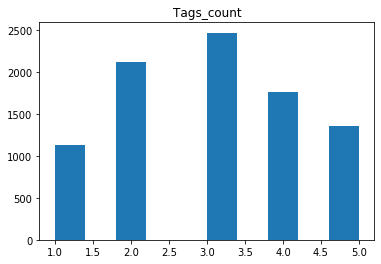

In [237]:
#Create column that contains the number of tags per question
questions['Tags_count'] = questions['Tags'].str.count('<')

#Plot histogram of Tags_count
questions.hist(column='Tags_count', grid=False, figsize=(6,4))

In [238]:
#Process Tags column to be able to use string methods
questions['Tags'] = questions['Tags'].str.replace('<','').str.replace('>',',').str[:-1]

In [239]:
#Split Tags column
questions['Tags'] = questions['Tags'].str.split(',')

In [240]:
print(questions.loc[2,'Tags'])
questions.head(2)

['python', 'time-series', 'forecast', 'forecasting']


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,Tags_count
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0,2
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0,4


# Exploring Most Popular Tags

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count **how many times the tag was used**, and **how many times a question with that tag was viewed**.

Additionally, we could take into account the **score**, or whether or not a question is part of someone's **favorite questions**. These are all reasonable options to investigate.

In [241]:
pop_columns=['Score', 'ViewCount', 'AnswerCount', 'FavoriteCount']
questions[pop_columns].describe()

,Score,ViewCount,AnswerCount,FavoriteCount
count,8839.000000,8839.000000,8839.000000,8839.000000
mean,0.870687,171.548026,0.787985,0.188596
std,1.410255,772.813626,0.851146,0.584422
min,-2.000000,2.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000
50%,1.000000,40.000000,1.000000,0.000000
75%,1.000000,98.000000,1.000000,0.000000
max,45.000000,33203.000000,9.000000,16.000000


We see that for each column the corresponding ranges are currently the following:
- scores: from -2 to 45,
- number of views: from 2 to 33204,
- number of answers: from 0 to 9,
- number of times a question was favored: from 0 to 16.

Next, we're going to create a **dataframe containing each unique tag with the number of times it was used in the questions**, sorted in descending order. Additionally, we'll create a dataframe for the TOP10 used tags.

In [242]:
tags_dict={}

for lst in questions['Tags']:
    for tag in lst:    
        if tag not in tags_dict:
            tags_dict[tag]=0
        tags_dict[tag]+=1

def create_sorted_df_from_dict(dictionary, new_df_column_name):
    """ function that: (1)Converts dictionary into dataframe, (2) 
        renames columns, (3)Sort values and (4)returns top-10 values"""
    df = pd.DataFrame.from_dict(dictionary, orient='index').reset_index()
    df.columns=['Tag',new_df_column_name]
    df = df.sort_values(new_df_column_name, ascending=False)
    return df, df.head(10)

#Execute function
tags_used, tags_used_top10 = create_sorted_df_from_dict(tags_dict,'Use Count')                                                       

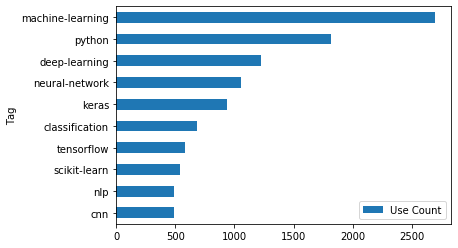

In [243]:
tags_used_top10.sort_values('Use Count').plot(kind='barh', x='Tag')

We can logically assume that the tags most used in questions ("Count") are the most popular ones and there should be a strong correlation with other measures of the tag popularity: scores, number of views, number of answers, and number of times each question with this tag was favored. We will extend out analysis to confirm this hypothesis.

In [244]:
# Defining a function for finding popular tags by column
def find_popular_tags(column_name, new_df_column_name):
    """The function return a dataframe with the most popular tags based
    on the column input (e.g. ViewCount)"""
    tags_dict={}

    for index, row in questions.iterrows():
        lst = row['Tags']
        popularity = row[column_name]
        for tag in lst:
            if tag not in tags_dict:
                tags_dict[tag]=0
            tags_dict[tag]+=popularity   
            
    #Transform dictionary into dataframe using previous function
    tags_df, tags_df_top10 = create_sorted_df_from_dict(tags_dict,
                                                        new_df_column_name)
    return tags_df, tags_df_top10
    

In [245]:
#Create dataframe for popular tags based on ViewCount
tags_views, tags_views_top10 = find_popular_tags('ViewCount', 'Views Count')

#Create dataframe for popular tags based on Score
tags_score, tags_score_top10 = find_popular_tags('Score', 'Score Count')

#Create dataframe for popular tags based on AnswerCount
tags_answer, tags_answer_top10 = find_popular_tags('AnswerCount', 'Answers Count')

#Create dataframe for popular tags based on FavoriteCount
tags_favorite, tags_favorite_top10 = find_popular_tags('FavoriteCount', 'Favourite Count')


In [246]:
#Merge all dataframes (outer)
tags_merged = tags_used.copy()
tags_merged = tags_merged.merge(tags_views, how='outer', on='Tag')
tags_merged = tags_merged.merge(tags_score, how='outer', on='Tag')
tags_merged = tags_merged.merge(tags_answer, how='outer', on='Tag')
tags_merged = tags_merged.merge(tags_favorite, how='outer', on='Tag')

In [247]:
print('Missing values (%):\n',
      tags_merged.isnull().sum()/len(tags_merged))

Missing values (%):
 Tag                0.0
Use Count          0.0
Views Count        0.0
Score Count        0.0
Answers Count      0.0
Favourite Count    0.0
dtype: float64


In [248]:
tags_merged.head(3)

,Tag,Use Count,Views Count,Score Count,Answers Count,Favourite Count
0,machine-learning,2693,388499,2515,2313,575
1,python,1814,537585,1475,1507,325
2,deep-learning,1220,233628,1127,877,266


In the merged dataframe we do not observe missing values, meaning tags that are popular based on one feature (e.g. use count) but not based on another one (e.g. Favourite count). 

Next, we will analize the **correlation** among the different tags based on the different popularity features

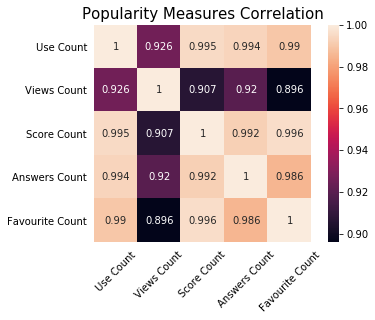

In [249]:
# Creating a correlation heatmap
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(tags_merged.corr(), annot=True, fmt='.3g', 
                 square=True)

ax.set_title('Popularity Measures Correlation', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(bottom=False, left=False)

We can clearly see that our assumption is confirmed: **there is a very strong correlation between all the popularity measures of the tags**. It means that the topics (reflected by the tag names) that stir the biggest interest among people asking questions usually attracts more views, and gathers more answers, scores, and favorite marks. An especially strong correlation is observed between scores and favorite marks. The least correlated popularity measure among all is the number of views.

Now we will focus on the **top10 tag per popularity measure** (use, views, score, answers, favourite):

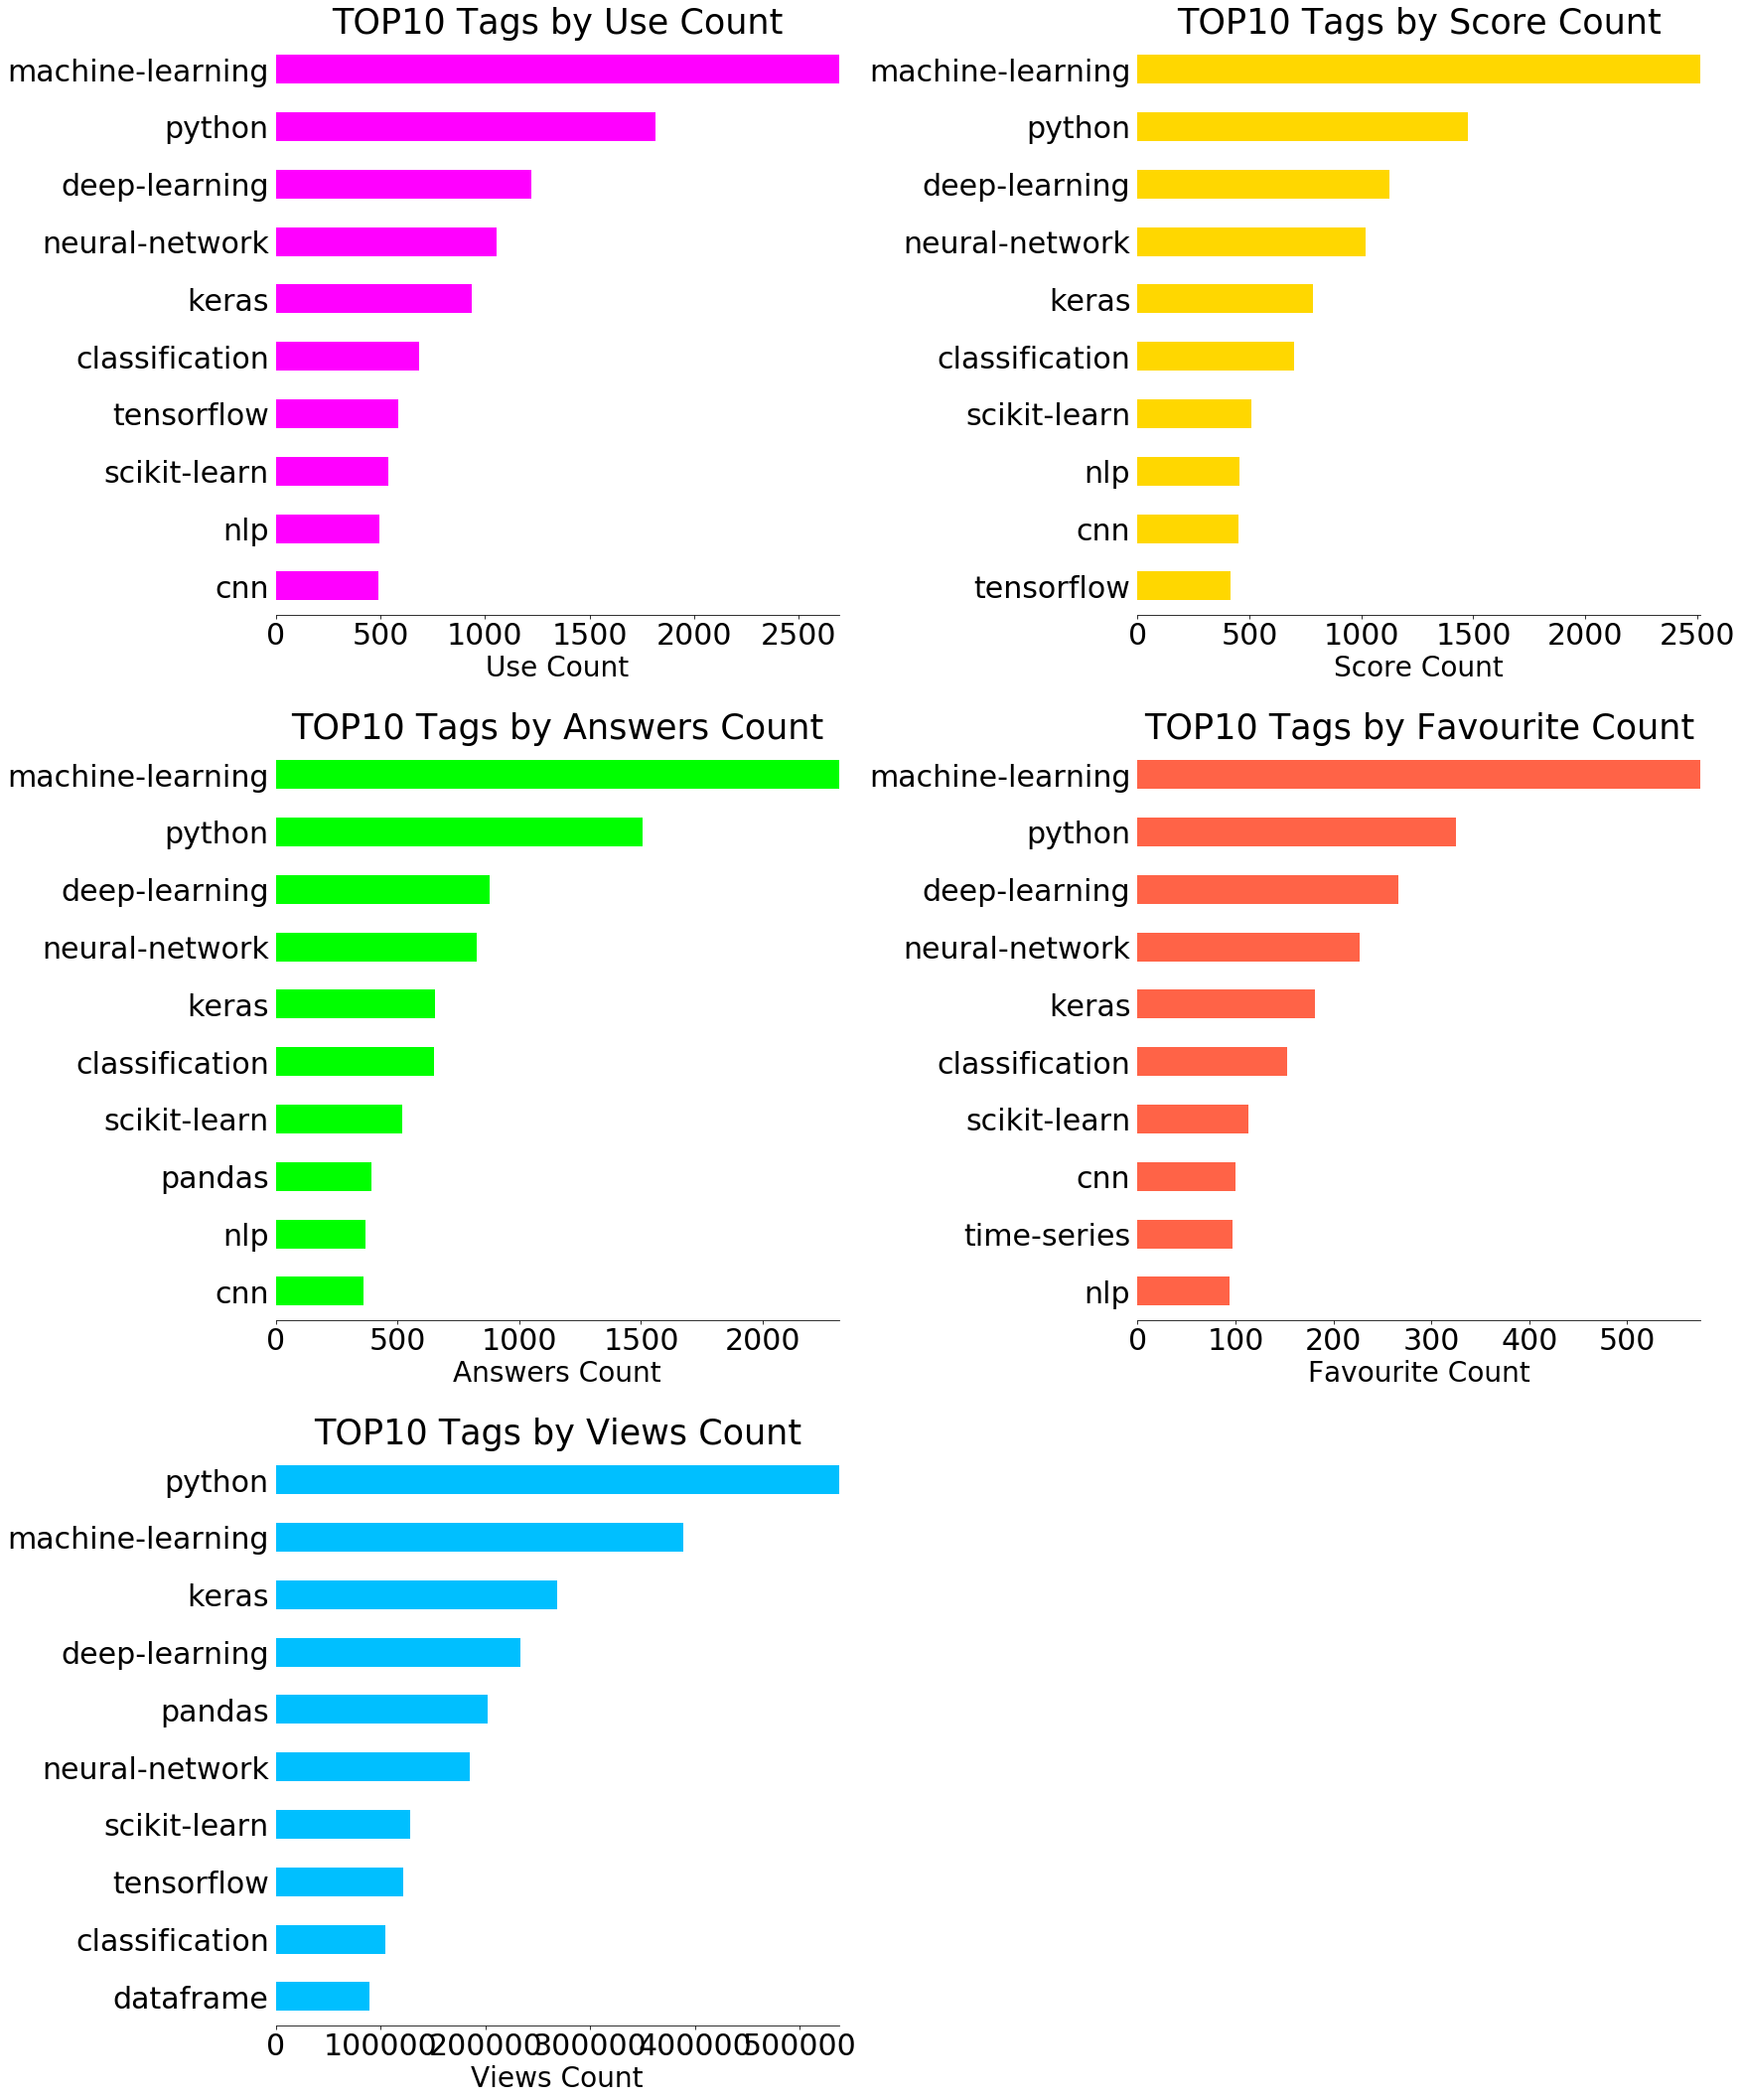

In [250]:
#Create a list with all dataframes
top10_dfs = [tags_used_top10, tags_score_top10, 
             tags_answer_top10, tags_favorite_top10,
             tags_views_top10]

#create empty lists to populate with data from top10_dfs
dfs=[]
columns=[]
titles=[]
xlims=[] 
colors = ['magenta', 'gold', 'lime', 'tomato', 'deepskyblue']

#Filling empty lists
for df in top10_dfs:
    dfs.append(df.copy().set_index('Tag', drop=True))
    columns.append(df.columns[1])
    titles.append('TOP10 Tags by {}'.format(df.columns[1]))
    xlims.append(df.max()[1])

#Plot horizontal bars
fig = plt.figure(figsize=(25, 30))
for i in range(0,5):
    ax = fig.add_subplot(3,2,i+1)   
    dfs[i][columns[i]].sort_values().plot.barh(color=colors[i],
                                 xlim=(0, xlims[i]),rot=0)
                                               
    ax.set_title(titles[i], fontsize=35)
    ax.set_ylabel(None)
    ax.set_xlabel(columns[i], fontsize=28)
    ax.tick_params(axis='both', labelsize=30, left = False)
    for j in ['top', 'right', 'left']:
        ax.spines[j].set_visible(False)
    plt.tight_layout(pad=3)   

Observations:
    - Machine Learning and Python are the top tags.
    - The great majority of tags are presented in all top10 dataframes
    
Next, we will check how many tags are present in all top10 dataframes

In [251]:
#Merge all top_10 dataframes (inner join)
top10_tags_merged = tags_used_top10.copy()
top10_tags_merged = top10_tags_merged.merge(tags_views_top10, 
                                            how='inner', on='Tag')
top10_tags_merged = top10_tags_merged.merge(tags_score_top10, 
                                            how='inner', on='Tag')
top10_tags_merged = top10_tags_merged.merge(tags_answer_top10, 
                                            how='inner', on='Tag')
top10_tags_merged = top10_tags_merged.merge(tags_favorite_top10, 
                                            how='inner', on='Tag')

In [252]:
print('Tags present in all Top10 dataframes:{}'.format(len(top10_tags_merged)))

top10_tags_merged

Tags present in all Top10 dataframes:7


,Tag,Use Count,Views Count,Score Count,Answers Count,Favourite Count
0,machine-learning,2693,388499,2515,2313,575
1,python,1814,537585,1475,1507,325
2,deep-learning,1220,233628,1127,877,266
3,neural-network,1055,185367,1021,824,227
4,keras,935,268608,785,654,181
5,classification,685,104457,701,651,153
6,scikit-learn,540,128110,507,518,113


# Engaging Domain Knowledge

All the visualizations so far showed that `machine-learning` is the most popular tag, with a big gap from all the others. This gives us a general trend, however we have to take into account that the sphere of **machine learning** itself is rather large and includes plenty of branches, approaches, and methods. It's not surprising then that so many questions are tagged with this topic, most probably, always (or almost always) in combination with some other tags. The same can be said about the tag on the second place, representing **Python**, the most popular programming language in data science and including quite a lot of things. Since our aim here is to find the best content for a data science learning resource, we should make our research narrower and more focused.

At a closer look, after some googling, we see that all the topics reflected by the 9 most popular tags above are actually all interrelated, and all can be united under a general giant topic: **Machine Learning**.
- **Deep learning** is a new area of *machine learning* research concerned with the technologies used for learning hierarchical representations of data, mainly done with *neural networks*.
- **Neural networks** are composed of programming constructs that mimic the properties of biological neurons. They are widely used in *deep learning* algorithms for solving artificial intelligence problems without the network designer having had a model of a real system.
- **Natural language processing (NLP)** is a subfield of linguistics, computer science, and artificial intelligence (a subset of which is *machine learning*) concerned with the interactions between computers and human language. A new paradigm of NLP, distinct from statistical NLP, is *deep learning* approaches based on *neural networks*. 
- **Scikit-learn** and **TensorFlow** are *machine learning* libraries,  the first one based on *Python*, the second - on *Python* and C++.
- **Keras** is a *deep learning* library that provides a *Python* interface for artificial *neural networks*.
- **Classification** is one of the algorithms of supervised *machine learning*.

From these definitions, we can discern a prospective direction for the content of our data science resource - **deep learning**. The corresponding tag, as well as those most closely related to it (`keras`and `neural-network`), goes at the 3rd place in all the TOP10 lists of the most popular tags, right after `machine-learning` and `python`. As mentioned above, it's also becoming a new concept for NLP. Finally, according to the [Wikipedia article](https://en.wikipedia.org/wiki/Machine_learning#:~:text=Machine%20learning%20(ML)%20is%20the,a%20subset%20of%20artificial%20intelligence) for machine learning:

> As of 2020, deep learning has become the dominant approach for much ongoing work in the field of machine learning.

Hence, being a relatively new, rising area, attracting more and more interest from both learners and data scientists, still quite a large topic, but already much more focused than machine learning in general, **deep learning seems to be a perfect candidate for a data science learning resource content**.

# Analysis of Deep Learning Interest Over Time

In this section we will **track the interest in Deep Learning over time**. For that purpose we have extracted all the questions available in SEDE and stored them in the file **all_questions.csv**

**SQL query:**    
    SELECT Id, CreationDate, Tags
    FROM posts
    WHERE PostTypeId = 1;

In [253]:
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
all_questions.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            21576 non-null  int64         
 1   CreationDate  21576 non-null  datetime64[ns]
 2   Tags          21576 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


The dataset has a total of 21576 entries without missing values. Next we will process the **CreationDate** and **Tags** columns. 

In [254]:
#Extract month and year and create yr_mon column
all_questions['yr_mon'] = \
(all_questions['CreationDate'].dt.year*100) + all_questions['CreationDate'].dt.month

In [255]:
#Process Tags column to be able to use string methods
all_questions['Tags'] = all_questions['Tags'].str.replace('<','').str.replace('>',',').str[:-1]

#Split Tags column
all_questions['Tags'] = all_questions['Tags'].str.split(',')

In [256]:
#Create new columns to store the count of ML-related Tags
all_questions['DL_tags']=0
all_questions['Rest_tags']=0

#We assume the below tags refer to the Deep-Learning Domain
#In reality there are many more - we will explore that later
DL_tags=['deep-learning','keras','tensorflow',
         'neural-network','cnn']

#Count the ML-related tags and the rest
for index, row in all_questions.iterrows():
    lst = row['Tags']
    for tag in lst:
        if tag in DL_tags:
            all_questions.loc[index,'DL_tags']+=1
        else: all_questions.loc[index,'Rest_tags']+=1

In [257]:
all_questions.head(3)

,Id,CreationDate,Tags,yr_mon,DL_tags,Rest_tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",201902,3,2
1,45418,2019-02-12 00:50:39,[neural-network],201902,1,0
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",201902,0,3


In [258]:
#Group questions by yr_mon and sum the tags per month
all_q_group = \
all_questions.groupby('yr_mon').sum()[['DL_tags','Rest_tags']].reset_index()

all_q_group['DL_pct']=100*(all_q_group['DL_tags']/(all_q_group['DL_tags']+
                                             all_q_group['Rest_tags']))

all_q_group['Total_tags']=(all_q_group['DL_tags']+
                       all_q_group['Rest_tags'])


In [259]:
all_q_group.head()

,yr_mon,DL_tags,Rest_tags,DL_pct,Total_tags
0,201405,1,151,0.657895,152
1,201406,7,240,2.834008,247
2,201407,7,176,3.825137,183
3,201408,1,170,0.584795,171
4,201409,1,118,0.840336,119


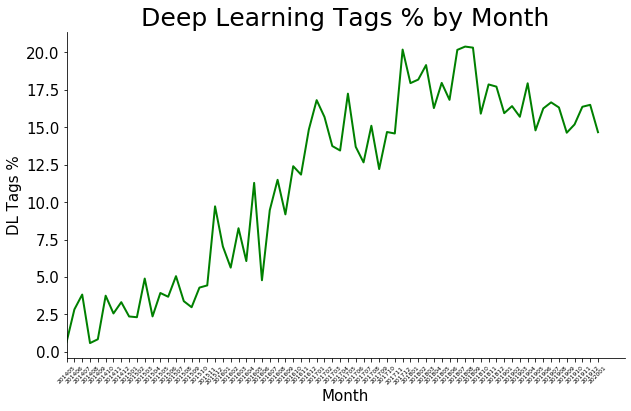

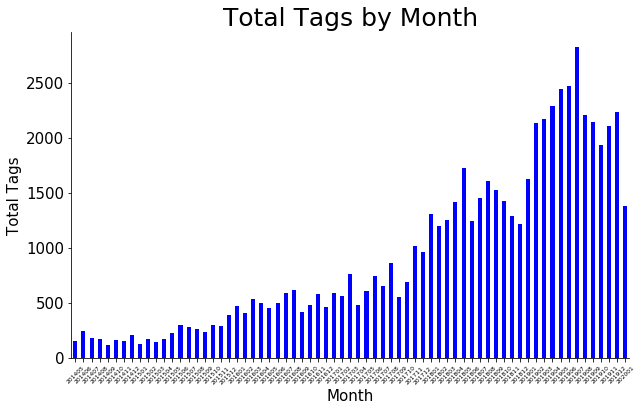

In [292]:
#Plot percentage of deep-learning related tags by month
all_q_group.plot(
                figsize=(10,6),
                y='DL_pct',
                xlim=0,
                linestyle='-', 
                color='green', 
                lw=2,
                fontsize=15, 
                legend=False)

plt.xlabel('Month', fontsize=15)
plt.ylabel('DL Tags %', fontsize=15)
plt.title('Deep Learning Tags % by Month', fontsize=25)
plt.xticks(np.arange(len(all_q_group)), 
           all_q_group['yr_mon'], 
            fontsize=6, rotation=45)
sns.despine()

#Plot total tags my month
all_q_group.plot(
                figsize=(10,6),
                kind='bar',
                y='Total_tags',
                xlim=0,
                #linestyle='-', 
                color='blue', 
                #lw=2,
                fontsize=15, 
                legend=False)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Total Tags', fontsize=15)
plt.title('Total Tags by Month', fontsize=25)
plt.xticks(np.arange(len(all_q_group)), 
           all_q_group['yr_mon'], 
            fontsize=6, rotation=45)
sns.despine()

Based on the results, not only the **ammount of questions has increased** over the time but **also the percentage of DL-related tags**. This confirms the **increase popularity of Deep Learning** and the business opportunity to extend this topic in the learning platform.

This initial analysis has some **assumptions** that may impact the overall insights:
- The **DL-related tags have been set arbitrarily** based on domain knowledge, in reality there are many more in the dataset.
- We have focused our analysis in the **amount of tags used rather than the questions containing DL-related** tags. Over time the amount of tags per questions may vary, producing misleading results.
    
In order to solve the above issues we will extend our analysis.

In [92]:
#Reload dataset extracting Id, CreationDate and Tags columns (the dataset is clean)
all_questions = all_questions[all_questions.columns[0:3]] 
all_questions.head(3)

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"


In [136]:
# Creating a list of all the tags ever used
all_tags = []
for lst in all_questions['Tags']:
    for tag in lst:
        if tag not in all_tags:
            all_tags.append(tag)

# Creating a list of sets of tags for each question that has `deep-learning` as one of the tags
dl_tags = []
for lst in all_questions['Tags']:
    if "deep-learning" in lst:
        dl_tags.append(lst)

# Creating a dictionary of all the tags used in combination with `deep-learning` and their frequencies
dl_tags_dict={}
for lst in dl_tags:
    for tag in lst:
        if tag not in dl_tags_dict:
            dl_tags_dict[tag]=0
        dl_tags_dict[tag]+=1

# Sorting the dictionary
sorted_dl_tags_dict= dict(sorted(dl_tags_dict.items(), reverse=True, key=operator.itemgetter(1)))

# Creating a list of all the tags that were used with the `deep-learning` tag, but sometimes were used also without it
dl_tags_not_exclusive = []
for lst in all_questions['Tags']:
    for item in list(sorted_dl_tags_dict.keys())[1:]: # avoiding checking `deep-learning` itself
         if ('deep-learning' not in lst) and (item in lst) and (item not in dl_tags_not_exclusive):
                dl_tags_not_exclusive.append(item)

# Printing the statistics and the dictionary
print('Number of all the questions in the DSSE:',  '\n',
      len(all_questions), '\n', '\n',
      'Number of questions with the `deep-learning` tag:', '\n', 
      len(dl_tags), '\n', '\n',
      'Overall number of all the tags in the DSSE database:', '\n', 
      len(all_tags), '\n', '\n',
      'Number of unique tags associated with `deep-learning`:',  '\n', 
      len(dl_tags_dict), '\n','\n',
      'Number of unique tags associated with `deep-learning`, but sometimes used without:', '\n',
      len(dl_tags_not_exclusive))

Number of all the questions in the DSSE: 
 21576 
 
 Number of questions with the `deep-learning` tag: 
 2805 
 
 Overall number of all the tags in the DSSE database: 
 559 
 
 Number of unique tags associated with `deep-learning`: 
 341 
 
 Number of unique tags associated with `deep-learning`, but sometimes used without: 
 334


From this analysis we can observe the following:
- 13% of the questions in the DSSE are flagged with 'deep-learning'.
- 61% of the total tags were used together with 'deep-learning'.
- 98% of the tags associated with 'deep-learning' were also used without it at least once.

This analysis confirms that there are more tags deeply related to 'deep-learning' but not used together and hence the number of amount of DL-related questions should be higher than 13%.

Taking the **dl_tags_dict** as a starting point and using our domain knowledge we have selected the tags that are intimately retaled to **deep-learning excluding generic tags and tags used in traditional machine learning**. This is the result:

In [177]:
dl_related_tags = {
                   'deep-learning': 3544,
                   'neural-network': 1143,
                   'keras': 665,
                   'cnn': 409,
                   'lstm': 240,
                   'convnet': 191,
                   'rnn': 133,
                   'autoencoder': 77,
                   'gan': 71,
                   'recurrent-neural-net': 55,
                   'backpropagation': 54,
                   'activation-function': 48,
                   'gpu': 42,
                   'deep-network': 39,
                   'dqn': 30,
                   'yolo': 28,
                   'mlp': 24,
                   'attention-mechanism': 23,
                   'dropout': 22,
                   'vgg16': 15,
                   'inception': 14,
                   'mini-batch-gradient-descent': 12,
                   'faster-rcnn': 11,
                   'gru': 10,
                   'caffe': 10,
                   'perceptron': 8,
                   'rbm': 8,
                   'stacked-lstm': 6,
                   'inceptionresnetv2': 6,
                   'ann': 6,
                   'alex-net': 6,
                   'siamese-networks': 5,
                   'neural-style-transfer': 4,
                   'pooling': 4,
                   'graph-neural-network': 4,
                   'vae': 3,
                   'fastai': 3,
                   'cs231n': 3,
                   'pretraining': 2,
                   'tflearn': 2,
                   'gnn': 2,
                   'allennlp': 1,
                   'rmsprop': 1,
                   'keras-rl': 1,
                   'pytorch-geometric': 1,
                   'mxnet': 1,
                  }

print('Number of tags specific to deep learning: ', len(dl_related_tags))

Number of tags specific to deep learning:  46


In [178]:
print('First question asked: ', all_questions['CreationDate'].min(),
      '\n',
      'Last question asked: ', all_questions['CreationDate'].max())

First question asked:  2014-05-13 23:58:30 
 Last question asked:  2019-12-31 18:08:12


We will consolidate our data in quarters and hence we would remove all entries in 2020 so that we have a complete quarter in the upper end

In [179]:
all_questions = all_questions[all_questions['CreationDate'].dt.year<2020]

We will create 2 new columns in all_questions:
- DL [0/1]: to identify if a question is related to Deep-Learning
- YearQuarter [YYYYQQ]: to consolidate the questions

In [182]:
#Create a list with all the tags in dl_related_tags 
dl_related_tags_list = list(dl_related_tags.keys())

#Create a function that return 0 or 1 if a question is related to Deep-Learning
def classify_dl(tags):
    """ The function return 0/1 if a question has a tag 
    related to deep-learning (from dl_related_tags_list list)"""
    for tag in tags:
        if tag in dl_related_tags_list:
            return 1
    return 0

# Defining a function for extracting the year and quarter
def extract_year_quarter(dt):
    """The function returns the year and quarter in the format YYYYQQ"""
    quarter = ((dt.month-1) // 3) + 1
    return dt.year*100+quarter

#Apply above functions
all_questions['DL'] = all_questions['Tags'].apply(classify_dl)
all_questions['YearQuarter'] = all_questions['CreationDate'].apply(extract_year_quarter)

In [208]:
#Group questions by YearQuarter 
questions_by_quarter = all_questions.groupby('YearQuarter').agg({'DL': ['sum', 'count']}).reset_index()

#Rename columns for clarity
questions_by_quarter.columns = ['YearQuarter','dl_questions','total_questions']

#Add pct column
questions_by_quarter['dl_questions_percent'] = \
round((questions_by_quarter['dl_questions']/questions_by_quarter['total_questions'])*100,2)

questions_by_quarter.head()

,YearQuarter,dl_questions,total_questions,dl_questions_percent
0,201402,7,157,4.46
1,201403,9,189,4.76
2,201404,15,216,6.94
3,201501,14,190,7.37
4,201502,20,284,7.04


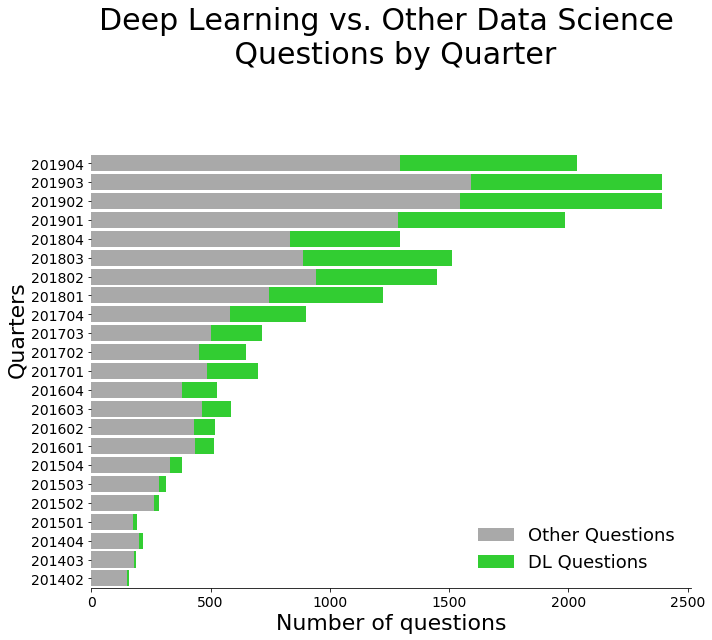

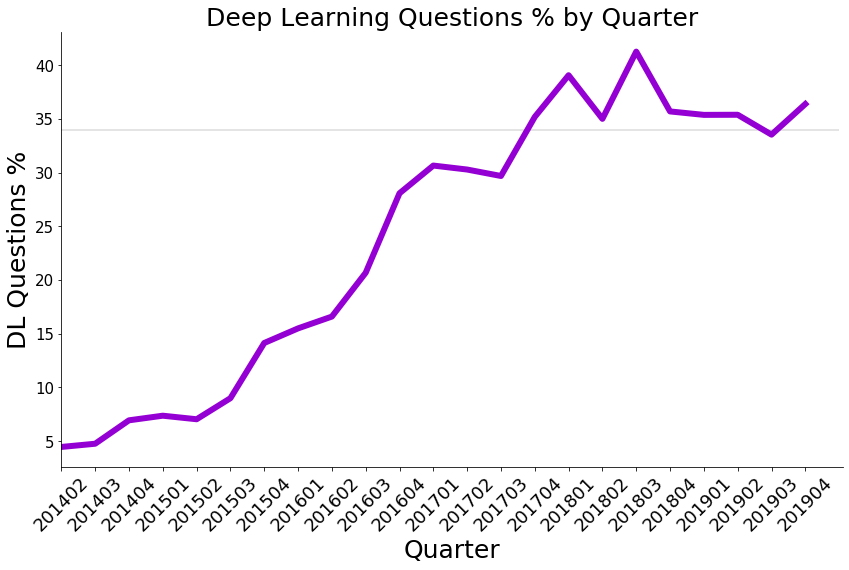

In [228]:
# CREATING A STACKED HORIZONTAL BAR PLOT FOR DL-RELATED AND OTHER QUESTIONS
#--------------------------------------------------------------------------

# Number of bars
N = len(questions_by_quarter)

# Data to plot
other_Q = questions_by_quarter['total_questions']-questions_by_quarter['dl_questions']
dl_Q = questions_by_quarter['dl_questions']

# X locations for the groups
ind = np.arange(N)

# Bar width 
width = 0.85

# Plotting the results
fig = plt.figure(figsize=(10,9))
p1 = plt.barh(ind, other_Q, width, color = 'darkgray')
p2 = plt.barh(ind, dl_Q, width, color = 'limegreen',left=other_Q)

plt.title('Deep Learning vs. Other Data Science \n Questions by Quarter', fontsize = 30)
plt.xlabel('Number of questions', fontsize=22)
plt.ylabel('Quarters', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(ind, questions_by_quarter['YearQuarter'], fontsize=14)
plt.legend(
           (p1[0], p2[0]), 
           ('Other Questions', 'DL Questions'), 
           frameon=False, 
           fontsize=18, 
           loc=4
           )
plt.ylim(-0.5,27)
plt.tight_layout()
sns.despine(left=True)
plt.show()
print('\n')

#--------------------------------------------------------------------------
# CREATING A LINE PLOT FOR THE PERCENTAGE OF DL-RELATED QUESTIONS BY QUARTER
#--------------------------------------------------------------------------
questions_by_quarter.plot(
                          figsize=(14,8),
                          #x='YearQuarter', 
                          y='dl_questions_percent',
                          kind='line', 
                          xlim=0, 
                          linestyle='-', 
                          color='darkviolet', 
                          lw=6,
                          fontsize=15, 
                          legend=False
                          )
plt.xlabel('Quarter', fontsize=25)
plt.ylabel('DL Questions %', fontsize=25)
plt.title('Deep Learning Questions % by Quarter', fontsize=25)
plt.xticks(ind, questions_by_quarter['YearQuarter'], fontsize=18, rotation=45)
plt.hlines(y=34, xmin=0, xmax=N, color='gainsboro')
sns.despine()

# Conclusion

In this project, we explored the database of Data Science Stack Exchange, with the **goal to figure out the most popular data science questions**, and, consequently, the **best content for a data science learning resource**. We focused on the most recent questions (2020) and then, to assure that the content we decide to create will be the most useful for as long as possible, we checked our findings over the whole period of existence of the DSSE (excluding just started 2021). The main approach was to explore the tags and the popularity measures related to the questions tagged with them: number of answers, views, scores, and favorite marks.

As a result, we found out that **deep learning is the most prospective direction for the content of our data science resource**. Being a relatively new, rising area of machine learning, but already representing the dominant approach for much ongoing work in this field, attracting more and more interest from both learners and data scientists, still quite a large topic, but much more focused than machine learning in general, deep learning seems to be a perfect candidate for our purposes.

Some insights and numbers obtained in this project:
- The number of data science questions in general has been constantly increasing over the whole time of existence of the DSSE (from 2014). There was a noticeable breakthrough in the beginning of 2018 and an evident peak in the 2nd quarter of 2020, the latter potentially related to the outbreak of the COVID-19 pandemia, subsequent lockdowns and growing interest in online learning, in particular in learning data science. 
- The percentage of deep learning questions was constantly growing up until middle of 2018, when it reached a plateau of 34%, which is still continuing, with a slight trend of growing. This means that the interest in deep learning is not slowing down over a long period of time.
- The overall percentage of all deep learning related questions on the DSSE is 32%.
